# Risk Prediction Model to Enhance Loan Approval Strategies

In [11]:
import pandas as pd

# load dataset
risk_data = pd.read_csv("germancredit.csv",)

# Factor the variable 'Outcome' (convert to categorical data)
risk_data['Default'] = pd.Categorical(risk_data['Default'])

risk_data.head()


,Default,checkingstatus1,duration,history,purpose,amount,savings,employ,installment,status,...,residence,property,age,otherplans,housing,cards,job,liable,tele,foreign
0,0,A11,6,A34,A43,1169,A65,A75,4,A93,...,4,A121,67,A143,A152,2,A173,1,A192,A201
1,1,A12,48,A32,A43,5951,A61,A73,2,A92,...,2,A121,22,A143,A152,1,A173,1,A191,A201
2,0,A14,12,A34,A46,2096,A61,A74,2,A93,...,3,A121,49,A143,A152,1,A172,2,A191,A201
3,0,A11,42,A32,A42,7882,A61,A74,2,A93,...,4,A122,45,A143,A153,1,A173,2,A191,A201
4,1,A11,24,A33,A40,4870,A61,A73,3,A93,...,4,A124,53,A143,A153,2,A173,2,A191,A201


In [12]:
risk_data.describe()

,duration,amount,installment,residence,age,cards,liable
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [13]:
X = risk_data.drop(columns=['Default'])
y = risk_data['Default']

In [33]:
risk_data.isna().sum()

,0
Default,0
checkingstatus1,0
duration,0
history,0
purpose,0
amount,0
savings,0
employ,0
installment,0
status,0


## Classification Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Create a LabelEncoder object
encoder = LabelEncoder()

# Iterate through columns of X and encode categorical features
for column in X.columns:
    if X[column].dtype == 'object':  # Check if the column is of object type (likely string)
        X[column] = encoder.fit_transform(X[column])


seed = 1
# Create the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=seed,max_leaf_nodes=11)

# Fit the model to the training data
dt_classifier.fit(X, y)

# Predict on the test data
y_pred = dt_classifier.predict(X)

# Calculate accuracy on the test data (You can use other metrics as well)
accuracy = accuracy_score(y, y_pred)

# Calculate misclassification error
misclassification_error = 1 - accuracy

print("Misclassification Error:", misclassification_error)


Misclassification Error: 0.22899999999999998


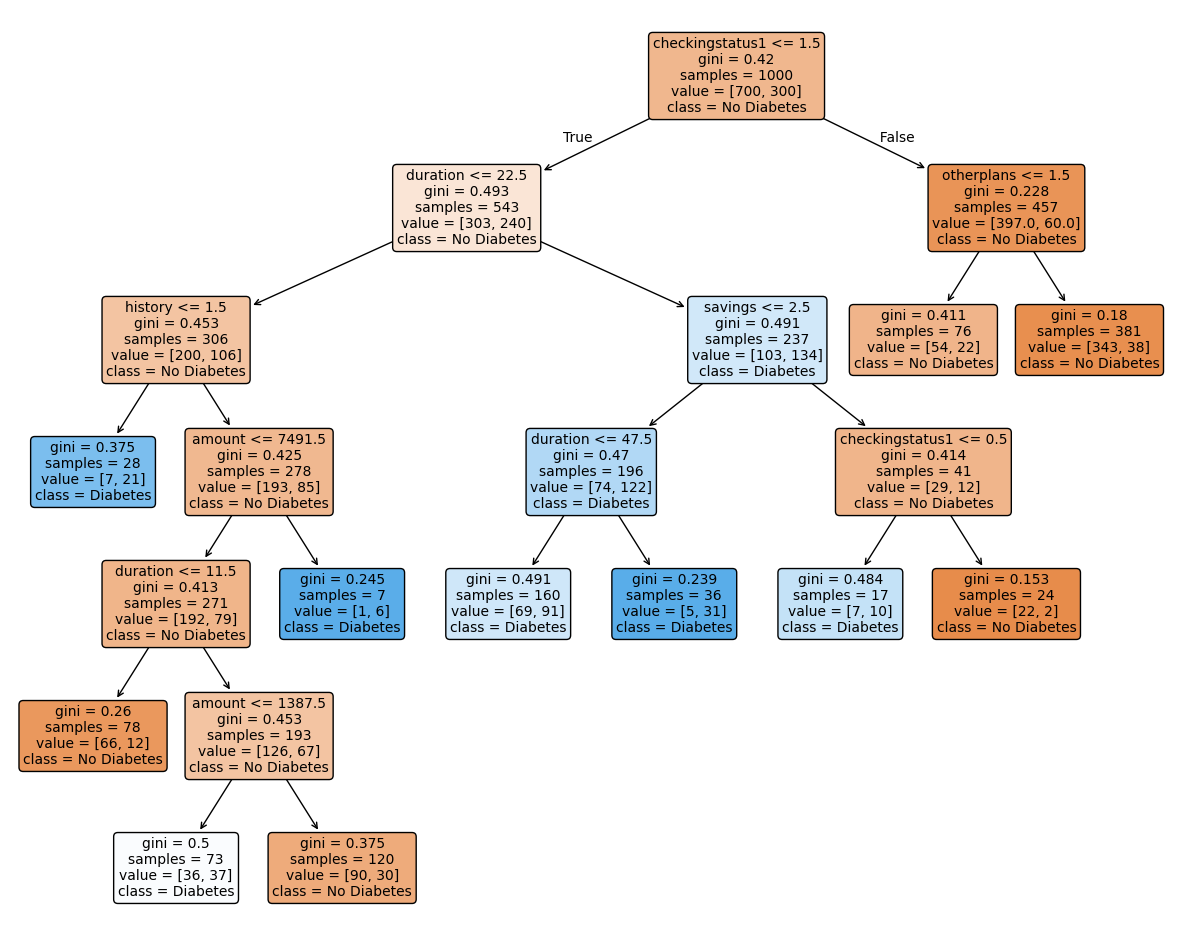

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
plot_tree(dt_classifier, filled=True, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], rounded=True, fontsize=10)
plt.show()

In [19]:
from sklearn.model_selection import LeaveOneOut
# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# List to store predicted target values for each iteration
y_pred_loocv = []

# Perform Leave-One-Out Cross-Validation
for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Create a new decision tree classifier
    dt_classifier = DecisionTreeClassifier(random_state=seed,max_leaf_nodes=11)

    # Fit the model on the current training set
    dt_classifier.fit(X_train, y_train)

    # Predict the target value using the test set
    y_pred = dt_classifier.predict(X_test)

    # Store the predicted target value for the current test sample
    y_pred_loocv.append(y_pred[0])

# Calculate accuracy for LOOCV
accuracy_loocv = accuracy_score(y, y_pred_loocv)

# Calculate misclassification error for LOOCV
misclassification_error_loocv = 1 - accuracy_loocv

print("Leave-One-Out Cross-Validation Misclassification Error:", misclassification_error_loocv)


Leave-One-Out Cross-Validation Misclassification Error: 0.277


In [20]:
import numpy as np
from sklearn.model_selection import cross_val_score
# Perform 10-fold cross-validation and get the deviance scores for each size
cv_scores = []
for size in range(2, X.shape[1] + 1):
    dt_classifier.set_params(max_leaf_nodes=size)  # Prune the tree with max_leaf_nodes=size
    scores = cross_val_score(dt_classifier, X, y, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

# Find the best-pruned tree size
best_pruned = np.argmin(cv_scores) + 2  # Adding 2 to the index because the range started from 2

print("Best Pruned Tree Size:", best_pruned)

Best Pruned Tree Size: 3


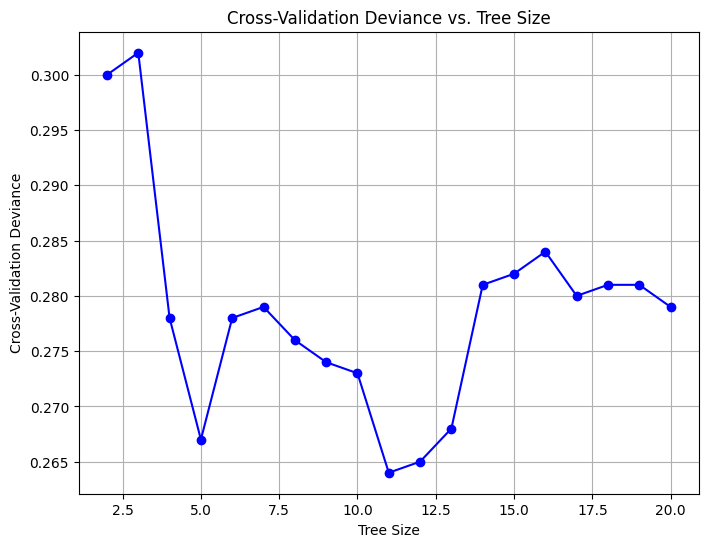

In [21]:
cv_sizes = []
cv_devs = []
for size in range(2, X.shape[1] + 1):
    dt_classifier.set_params(max_leaf_nodes=size)  # Prune the tree with max_leaf_nodes=size
    scores = cross_val_score(dt_classifier, X, y, cv=10, scoring='neg_mean_squared_error')
    mean_dev = -scores.mean()  # Calculate the mean of the negative mean squared error (negate again to get positive)
    cv_sizes.append(size)
    cv_devs.append(mean_dev)

# Plot the cross-validation deviance against tree size
plt.figure(figsize=(8, 6))
plt.plot(cv_sizes, cv_devs, 'bo-')
plt.xlabel('Tree Size')
plt.ylabel('Cross-Validation Deviance')
plt.title('Cross-Validation Deviance vs. Tree Size')
plt.grid(True)
plt.show()

# Prune the tree to obtain the best-pruned tree

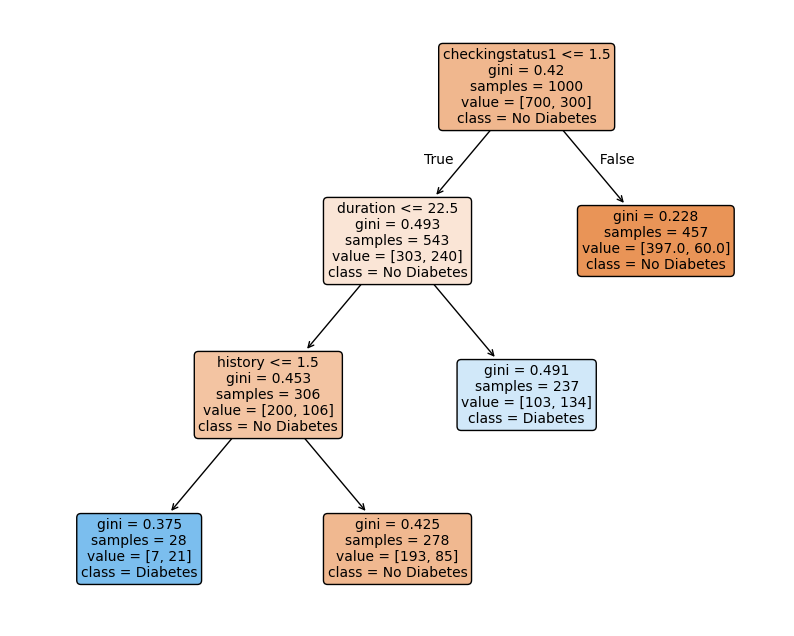

In [22]:
# Prune the tree to obtain the best-pruned tree with max_leaf_nodes = 4
dt_pruned = DecisionTreeClassifier(max_leaf_nodes=4, random_state=seed)
dt_pruned.fit(X, y)

# Plot the best-pruned tree
plt.figure(figsize=(10, 8))
plot_tree(dt_pruned, filled=True, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], rounded=True, fontsize=10)
plt.show()

In [26]:
def LOOCV_pruned(data):
    n = len(data)
    tree_pred_fit_pruned = []
    for i in range(n):
        newdata = data.drop(index=i)
        testdata = data.loc[[i]]

        # Create a new decision tree classifier
        dt_classifier = DecisionTreeClassifier(random_state=seed)

        # ----> Apply Label Encoding to newdata and testdata <----
        from sklearn.preprocessing import LabelEncoder
        encoder = LabelEncoder()
        for column in newdata.drop(columns=['Default']).columns:
            if newdata[column].dtype == 'object':
                newdata[column] = encoder.fit_transform(newdata[column])
                # Fit using newdata and transform testdata
                testdata[column] = encoder.transform(testdata[column])

        # Fit the model on the current training set
        dt_classifier.fit(newdata.drop(columns=['Default']), newdata['Default'])

        # Prune the tree to obtain the best-pruned tree with max_leaf_nodes = 4
        dt_pruned = DecisionTreeClassifier(max_leaf_nodes=4, random_state=seed)
        dt_pruned.fit(newdata.drop(columns=['Default']), newdata['Default'])

        # Predict the target value using the test set
        y_pred = dt_pruned.predict(testdata.drop(columns=['Default']))

        # Store the predicted target value for the current test sample
        tree_pred_fit_pruned.append(y_pred[0])

    MSE = 1 - accuracy_score(data['Default'], tree_pred_fit_pruned)
    return {'MSE': MSE, 'tree_pred_fit_pruned': tree_pred_fit_pruned}

In [30]:
# Perform LOOCV for the pruned tree and get the tree predictions
test_MSE_pruned = LOOCV_pruned(data=risk_data)
tree_pred_fit_pruned = test_MSE_pruned['tree_pred_fit_pruned']

# Calculate the table
table_result_pruned = pd.crosstab(index=pd.Series(tree_pred_fit_pruned), columns=risk_data['Default'])
print(table_result_pruned)

# Calculate misclassification error
incorrect_predictions = table_result_pruned.iloc[0, 1] + table_result_pruned.iloc[1, 0]
total_predictions = table_result_pruned.values.sum()

misclassification_error = incorrect_predictions / total_predictions
print(f"Misclassification Error: {misclassification_error:.3f}")


Default    0    1
row_0            
0        590  145
1        110  155
Leave-One-Out Cross-Validation Misclassification Error: 0.255
Misclassification Error: 0.255


,Feature,Importance
4,amount,0.147286
0,checkingstatus1,0.122696
12,age,0.108058
1,duration,0.101092
3,purpose,0.060480
2,history,0.059589
6,employ,0.050657
5,savings,0.046604
11,property,0.041715
7,installment,0.038800


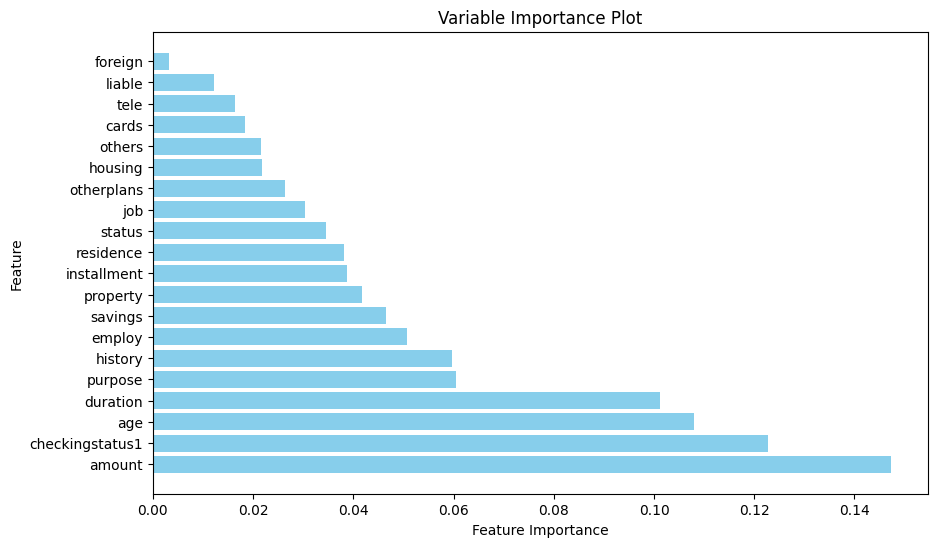

In [31]:
from sklearn.ensemble import RandomForestClassifier
# Create the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=1000, max_features=8, random_state=seed)

# Fit the model to the data
rf_classifier.fit(X, y)

# Get the feature importance scores
importance_scores = rf_classifier.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

display(importance_df)

# Plot the variable importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Variable Importance Plot')
plt.show()

## Bagging

In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
# Create a BaggingClassifier object with 15 base decision tree classifiers
bag = BaggingClassifier(n_estimators=15, random_state=seed)

# Train the BaggingClassifier on the training data
bag.fit(X, y)

# Make predictions on the test dataset
predictions = bag.predict(X)

# Get the predicted probabilities for each class for the test dataset
predicted_probas = bag.predict_proba(X)

# Calculate the accuracy of the model
accuracy = accuracy_score(y, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.994


In [36]:
def LOOCV_bagging(data):
    loo = LeaveOneOut()
    n = len(data)
    correct_predictions = 0
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create a BaggingClassifier with 15 base decision tree classifiers
        bag = BaggingClassifier(n_estimators=15, random_state=seed)

        # Train the BaggingClassifier on the training data
        bag.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = bag.predict(X_test)

        # Check if the prediction is correct and update the count
        if y_pred[0] == y_test.iloc[0]:
            correct_predictions += 1

    # Calculate the misclassification error rate
    misclassification_error_rate = 1 - (correct_predictions / n)
    return misclassification_error_rate

# Perform LOOCV for bagging and calculate the misclassification error rate
misclassification_error_rate = LOOCV_bagging(data=risk_data)
print("Misclassification Error Rate:", misclassification_error_rate)

Misclassification Error Rate: 0.242


Random Forest

In [37]:
from xgboost import plot_importance
rf_classifier = RandomForestClassifier(n_estimators=1000, max_features=round(X.shape[0]/3), random_state=seed)

# Fit the model to the data
rf_classifier.fit(X, y)

# Get the feature importance scores
importance_scores = rf_classifier.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(importance_df)

            Feature  Importance
4            amount    0.155957
0   checkingstatus1    0.134069
12              age    0.109948
1          duration    0.104702
3           purpose    0.061349
2           history    0.053845
6            employ    0.050991
5           savings    0.046242
11         property    0.040603
10        residence    0.036763
7       installment    0.034307
8            status    0.032616
16              job    0.027282
13       otherplans    0.026084
9            others    0.024324
14          housing    0.017717
15            cards    0.017013
18             tele    0.013876
17           liable    0.009817
19          foreign    0.002496


<Figure size 1000x600 with 0 Axes>

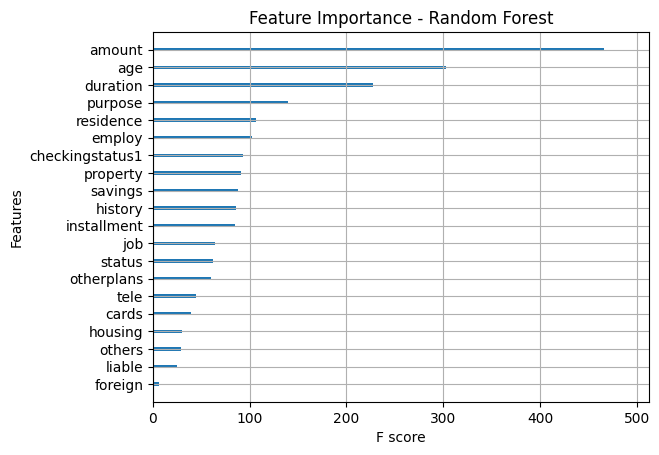

In [38]:
# Convert the Random Forest model to an XGBoost format
import xgboost as xgb
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X, y)

# Create the feature importance plot using plot_importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='weight', show_values=False)
plt.title('Feature Importance - Random Forest')
plt.show()

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

def k_fold_random_forest(data, k=5):
    X = data.drop(columns=["Default"])  # Replace "Default" with your target column
    y = data["Default"]

    # Initialize LabelEncoder
    encoder = LabelEncoder()

    # Iterate through columns of X and encode categorical features
    for column in X.columns:
        if X[column].dtype == 'object':  # Check if the column is of object type (likely string)
            X[column] = encoder.fit_transform(X[column])

    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    accuracies = []

    for train_index, test_index in kf.split(X):
        # Split the data into training and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create a Random Forest Classifier
        rf_classifier = RandomForestClassifier(
            n_estimators=100,               # Use fewer trees for faster cross-validation
            max_features=round(X.shape[1]/3), # Randomly selected features per split
            random_state=42
        )

        # Fit the model
        rf_classifier.fit(X_train, y_train)

        # Predict on the test set
        y_pred = rf_classifier.predict(X_test)

        # Calculate accuracy and store it
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Calculate the average misclassification rate
    misclassification_rate = 1 - (sum(accuracies) / k)
    return misclassification_rate

# Perform K-Fold CV on your data
misclassification_rate = k_fold_random_forest(data=risk_data, k=5)
print("Misclassification Rate:", misclassification_rate)

Misclassification Rate: 0.235


ADABoost

In [50]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

# Create a decision tree classifier with max_depth=1
dt_classifier = DecisionTreeClassifier(max_depth=1, random_state=seed)

# Create the AdaBoost classifier with 1000 estimators (trees)
#boost_classifier = AdaBoostClassifier(base_estimator=dt_classifier, n_estimators=1000, random_state=seed)
boost_classifier = AdaBoostClassifier(estimator=dt_classifier, n_estimators=1000, random_state=seed) #
# Fit the model to the data
boost_classifier.fit(X, y)

# Make predictions on the data
predictions = boost_classifier.predict(X)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y, predictions)
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[[654  46]
 [ 93 207]]


In [51]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold  # Import KFold for 5-fold CV
from sklearn.preprocessing import LabelEncoder

def k_fold_adaboost(data, k=5):
    """
    Performs k-fold cross-validation with AdaBoost on the given data.

    Args:
        data (pd.DataFrame): The dataset containing features and target.
        k (int, optional): The number of folds for cross-validation. Defaults to 5.

    Returns:
        float: The misclassification error rate.
    """
    X = data.drop(columns=["Default"])  # Separate features
    y = data["Default"]  # Separate target

    # Initialize KFold for 5-fold CV
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)

    correct_predictions = 0
    total_predictions = 0

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()  # Create copies
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize LabelEncoder inside the loop
        encoder = LabelEncoder()

        # Iterate through columns of X_train and encode categorical features
        for column in X_train.columns:
            if X_train[column].dtype == 'object':
                # Use .loc for indexing to avoid SettingWithCopyWarning
                X_train.loc[:, column] = encoder.fit_transform(X_train[column])
                # Use the same encoder to transform X_test
                X_test.loc[:, column] = encoder.transform(X_test[column])


        # Create a decision tree classifier with max_depth=1
        dt_classifier = DecisionTreeClassifier(max_depth=1, random_state=seed)

        # Create the AdaBoost classifier with 1000 estimators
        boost_classifier = AdaBoostClassifier(estimator=dt_classifier, n_estimators=1000, random_state=seed)
        # Updated to 'estimator'

        # Fit the model on the training data
        boost_classifier.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = boost_classifier.predict(X_test)

        # Update correct and total predictions
        correct_predictions += sum(y_pred == y_test)
        total_predictions += len(y_test)

    # Calculate the misclassification error rate
    misclassification_rate = 1 - (correct_predictions / total_predictions)
    return misclassification_rate

# Perform 5-fold CV and calculate the misclassification error rate
misclassification_rate = k_fold_adaboost(data=risk_data, k=5)
print("Misclassification Error Rate (5-Fold):", misclassification_rate)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Misclassification Error Rate (5-Fold): 0.278


In [48]:
# Sample data for the table
test_error_rate = {
    'Method': ["un-pruned tree" , "pruned tree" , " bagging" ,"random-forest" ,"boosting"],
    'Miss classification error rate': [0.277,0.255, 0.242,  0.235, 0.278],
}

# Create a DataFrame from the data dictionary
df_error = pd.DataFrame(test_error_rate)

# Display the DataFrame (table)
display(df_error)

,Method,Miss classification error rate
0,un-pruned tree,0.277
1,pruned tree,0.255
2,bagging,0.242
3,random-forest,0.235
4,boosting,0.278
